In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Binarizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("../data/train.csv", sep=",")

In [3]:
X = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin', 'Name']]
y = df['Survived']
X_train, X_test, y_train_real, y_test_real = train_test_split(X, y, test_size=0.2, random_state=151)

In [4]:
# df.loc[df['Age'].isna(), 'Age'] = df.groupby(by=['Sex', 'Pclass'])['Age'].transform('mean')
# df

In [5]:
def age_by_group(df):
    df.loc[df['Age'].isna(), 'Age'] = df.groupby(by=['Sex', 'Pclass'])['Age'].transform('mean')
    return df.copy(deep=True)

In [6]:
def cabin_to_deck(df):  
    df.loc[df['Cabin'].notna(), 'Cabin'] = df[df['Cabin'].notna()]['Cabin'].astype(str).str[0]
    return df.copy(deep=True)

In [7]:
def add_family_size(df: pd.DataFrame):
#     SibSp
#     Parch
    df.loc[(df['SibSp'] >= 5), 'family_tshirt_size'] = 'XL'
    df.loc[(df['SibSp'] >= 3) & (df['SibSp'] < 5), 'family_tshirt_size'] = 'L'
    df.loc[(df['SibSp'] == 2), 'family_tshirt_size'] = 'M'
    df.loc[(df['SibSp'] == 1), 'family_tshirt_size'] = 'S'

    return df.copy(deep=True)


# add_family_size(X_train)

In [8]:
# X_train['Fare'].isna().value_counts()

In [9]:
pipeline = make_pipeline(
        FunctionTransformer(age_by_group),
        FunctionTransformer(cabin_to_deck),
        FunctionTransformer(add_family_size),
        ColumnTransformer([
            ('quantile_age', KBinsDiscretizer(n_bins=3, strategy='quantile'), ['Age']),
            ('quantile_fare', KBinsDiscretizer(n_bins=3, strategy='quantile'), ['Fare']),
            ('ohe_and_sex', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Sex']),
            ('ohe_deck', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Cabin']),
            ('ohe_family_tshirt_size', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['family_tshirt_size']),
            ('do_nothing', 'passthrough', ['Pclass']),
            ('family_with_kids', Binarizer(), ['Parch'])
        ], remainder='drop'),
    )

In [56]:
pipeline.fit(X_train)

X_train_fe = pipeline.transform(X_train)

# pd.DataFrame(X_train_fe)

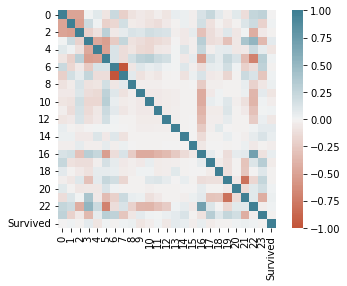

In [58]:
import seaborn as sns

df_train_fe = pd.DataFrame(X_train_fe).join(y_train_real)

ax = sns.heatmap(
    df_train_fe.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

In [11]:
m = LogisticRegression()
m.fit(X_train_fe, y_train_real)
# y_pred = m.predict(X_train_fe)

LogisticRegression()

### Evaluate Classifiers

In [41]:
from sklearn import metrics
# .metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, plot_roc_curve
import matplotlib.pyplot as plt
# from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
# from sklearn.metrics import recall_score
# from sklearn.metrics import f1_score

In [13]:
X_test_fe = pipeline.transform(X_test)
y_test_pred = m.predict(X_test_fe)

In [14]:
# print('score train data: %0.4f' % m.score(X_train_fe, y_train_real))
# print('score test data: %0.4f' % m.score(X_test_fe, y_test_real))

In [42]:
metrics.confusion_matrix(y_test_real, y_test_pred)

array([[102,  12],
       [ 26,  39]])

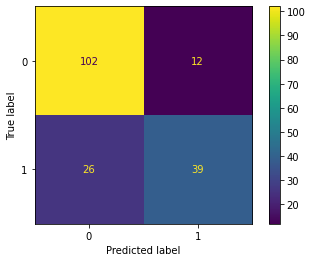

In [45]:
clf = SVC(random_state=0)
clf.fit(X_train_fe, y_train_real)

ConfusionMatrixDisplay.from_estimator(clf, X_test_fe, y_test_real)

plt.show()

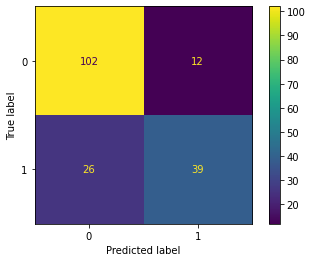

In [46]:
clf = SVC(random_state=0)
clf.fit(X_train_fe, y_train_real)

y_test_pred = clf.predict(X_test_fe)
ConfusionMatrixDisplay.from_predictions(y_test_real, y_test_pred)

plt.show()

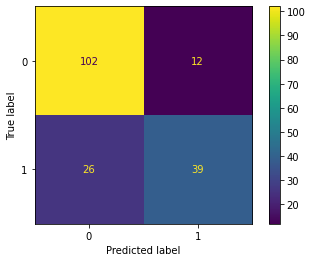

In [47]:
clf = SVC(random_state=0)
clf.fit(X_train_fe, y_train_real)

y_test_pred = clf.predict(X_test_fe)
cm = confusion_matrix(y_test_real, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

plt.show()

In [48]:
metrics.accuracy_score(y_test_real, y_test_pred)

0.7877094972067039

In [49]:
metrics.precision_score(y_test_real, y_test_pred)

0.7647058823529411

In [50]:
metrics.recall_score(y_test_real, y_test_pred)

0.6

In [51]:
metrics.f1_score(y_test_real, y_test_pred)

0.6724137931034482

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


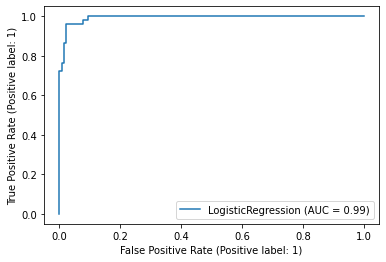

In [54]:
metrics.plot_roc_curve(m, X_test_fe, y_test_pred)

### Submit predictions to Kaggle

In [59]:
X_data_kaggle = pd.read_csv("../data/test.csv", sep=",")
X_test_kaggle = X_data_kaggle.loc[:, ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin', 'Name']]
# X_test_kaggle.isna().sum()

In [21]:
fare_mean = X_test_kaggle['Fare'].mean()
X_test_kaggle['Fare'].fillna(fare_mean, inplace=True)

In [60]:
# X_test_kaggle.isna().sum()

In [23]:
X_test_kaggle_fe = pipeline.transform(X_test_kaggle)

In [61]:
df_kaggle = pd.DataFrame({
    "PassengerId": X_data_kaggle['PassengerId'],
    "Survived": m.predict(X_test_kaggle_fe)
})
# df_kaggle

In [25]:
df_kaggle.to_csv("./output/titanic_predictions.csv", index=False)